# PlotBot



### Imports

In [1]:
# Core
from datetime import date
from operator import itemgetter
import json
import re

# Logging
import sys
import logging
logging.basicConfig(
    format='%(asctime)s | %(levelname)s : %(message)s',
    stream=sys.stdout) # Needed in Jupyter. Comment out if only need to see in log file.

# Scheduler
import schedule

# Numpy, Pandas and PyPlot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style(
    'darkgrid', 
    {
        'axes.facecolor': '0.9',
        'axes.titlesize': 'x-large',
        'figure.titlesize': 'x-large',
    }
)

# API
import tweepy
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Own
from twitter_config import *

### Constants and Globals

In [2]:
SLEEP_MINUTES = 5
SLEEP_SECONDS = 60 * SLEEP_MINUTES
PAGE_SIZE = 2
PAGES = 2
TODAY = date.today().strftime('%m/%d/%y')
TARGET_USER = 'feng443'

_AUTH = tweepy.OAuthHandler(TWITTER_CONSUMER_KEY, TWITTER_CONSUMER_SECRET)
_AUTH.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_TOKEN_SECRET)

TWITTER_API = tweepy.API(_AUTH, parser=tweepy.parsers.JSONParser())
SENTIMENT_ANALYZER = SentimentIntensityAnalyzer()

TWITTER_USER='feng443'

DEBUG = True
LOG_FILE = 'PlotBot.log'

### Define PlotBot Class

In [ ]:
class PlotBot(object):
    
    _analyzed = []
    _to_analyze = []
    _df = pd.DataFrame(index=pd.Index(
        list(range(-PAGE_SIZE * PAGES)),
        name='Tweets Ago'))
    
    @property
    def data(self):
        return self._df

    @property
    def logger(self):
        logger = logging.getLogger('PlotBot')
        if self._debug:
            logger.setLevel(logging.DEBUG)
        if self._log_file:
            logger.addHandler(logging.FileHandler(self._log_file))
        return logger
    
    def __init__(self, user=TWITTER_USER, debug=False, log_file=None):
        self._user = user
        self._re = re.compile('@PlotBot Analyze: @(\w{1,15})')
        self._debug = debug
        self._log_file = log_file
        
    def _scan_tweets(self, user=TWITTER_USER, debug=True):
        self.logger.info('Scan tweets ...')
        self._tweets = []
        for tweet in TWITTER_API.user_timeline(user, count=PAGE_SIZE):
            targets = self._re.findall(tweet['text'])
            if targets:
                target = targets[0]
                if target not in self._analyzed:
                    self._to_analyze.append(target)
                    
                else:
                    self.logger.info(f'{target} already analyzed. Skip.')
    
    def _analyze_all(self):
        if not self._to_analyze:
            self.logger.info('Nothing new.')
            return

        self.logger.info('Analyze all ...')
        while self._to_analyze:
            target = self._to_analyze.pop()
            self._analyzed.append(target)
            self._analyze(target)
        self._plot()
        self._tweet_out()
    
    def _analyze(self, target):
        self.logger.info(f'Analyze {target}')
        tweets_ago = 0
        for page in range(PAGES):
            for tweet in TWITTER_API.user_timeline(target, count=PAGE_SIZE, page=page):
                self._df.at[tweets_ago, 
                        f'@{target}'] = SENTIMENT_ANALYZER.polarity_scores(tweet['text'])['compound']
                tweets_ago -= 1
    
    def _plot(self):
        fig, ax = plt.subplots(figsize=(8, 6))
        bot.data.plot.line(
            marker='o',
            ax=ax,
            alpha=0.8,
        )
        plt.legend(
            title='Tweets',
            bbox_to_anchor=(1.25, 1)
        )
        plt.title(f'Sentiments Analysis of Tweet ({TODAY})',
            fontsize=16)
        plt.ylabel('Tweet Polarity')
        plt.gca().invert_xaxis()
        
        plt.savefig('plot_bot.png', bbox_inches='tight')
        plt.show()
        
    def _tweet_out(self):
        self.logger.info('Tweet out  ...')
        TWITTER_API.update_with_media('plot_bot.png',
                                      f'Sentiment Analsyis of Tweets ({TODAY})')
        
    def listen(self):
        self._scan_tweets()
        self._analyze_all()

### Start the Daemon

2018-03-18 17:35:29,325 | INFO : Scan tweets ...
2018-03-18 17:35:29,593 | INFO : Analyze all ...
2018-03-18 17:35:29,595 | INFO : Analyze CNN
2018-03-18 17:35:30,357 | INFO : Analyze CBS


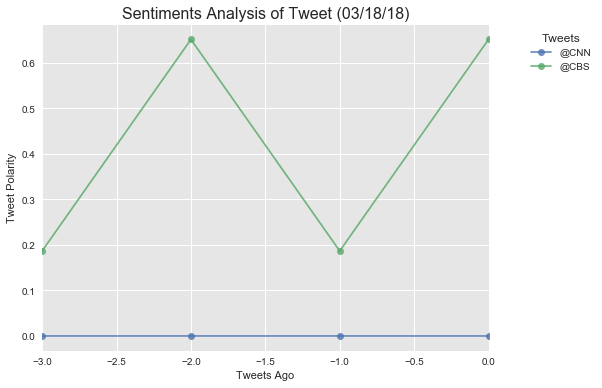

2018-03-18 17:35:42,382 | INFO : Scan tweets ...
2018-03-18 17:35:42,661 | INFO : CBS already analyzed. Skip.
2018-03-18 17:35:42,664 | INFO : Nothing new.
2018-03-18 17:35:52,666 | INFO : Scan tweets ...
2018-03-18 17:35:52,952 | INFO : CBS already analyzed. Skip.
2018-03-18 17:35:52,954 | INFO : Nothing new.
2018-03-18 17:36:02,956 | INFO : Scan tweets ...
2018-03-18 17:36:03,185 | INFO : CBS already analyzed. Skip.
2018-03-18 17:36:03,187 | INFO : CNN already analyzed. Skip.
2018-03-18 17:36:03,189 | INFO : Nothing new.


In [ ]:
schedule.clear()
bot = PlotBot(debug=DEBUG, log_file=LOG_FILE)
schedule.every(10).seconds.do(bot.listen)
    
while True:
    schedule.run_pending()